# 📌 Eksplorasi dan Analisis Foto Kucing dan Anjing 

# 1. Import Library

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import hashlib
import numpy as np
import imagehash
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from torchvision import models, transforms, datasets
from torchvision.models import ResNet18_Weights
from sklearn.manifold import TSNE

# 2. Load Dataset

In [2]:
base_dir = "cats-dogs"

# 3. Ekplorasi data


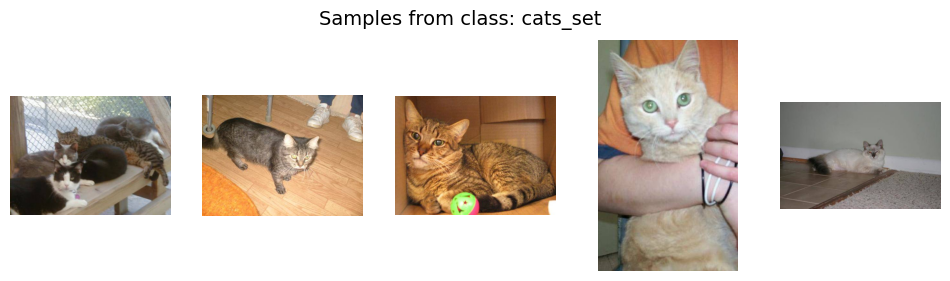

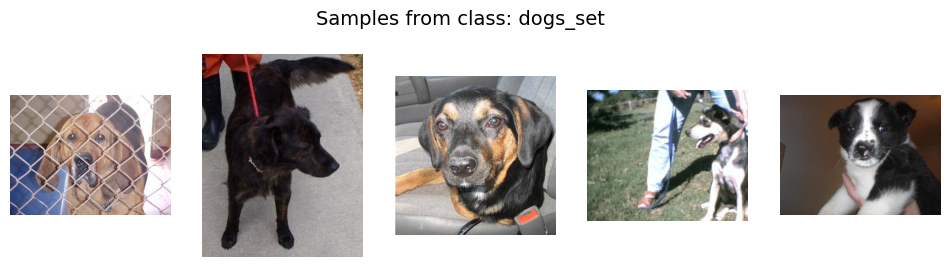

In [3]:
def show_samples_per_class(base_dir, n=5):
    classes = [cls for cls in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, cls))]
    
    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        images = random.sample(os.listdir(cls_path), min(n, len(os.listdir(cls_path))))
        
        plt.figure(figsize=(12,3))
        plt.suptitle(f"Samples from class: {cls}", fontsize=14)
        
        for i, img_name in enumerate(images):
            img_path = os.path.join(cls_path, img_name)
            try:
                img = Image.open(img_path)
                plt.subplot(1, n, i+1)
                plt.imshow(img)
                plt.axis("off")
            except:
                continue
        plt.show()

show_samples_per_class(base_dir, n=5)

Menghitung jumlah gambar pada setiap kelas

In [4]:
class_counts = {}

for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    if os.path.isdir(cls_path):
        count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.png','.jpeg'))])
        class_counts[cls] = count

print("Jumlah gambar per kelas:", class_counts)
print("Total gambar:", sum(class_counts.values()))

Jumlah gambar per kelas: {'cats_set': 500, 'dogs_set': 500}
Total gambar: 1000


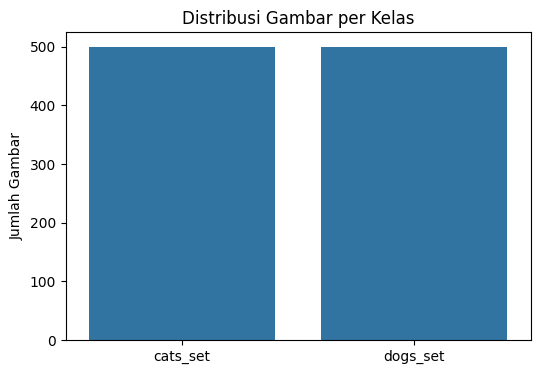

In [5]:
# 4. Plot distribusi kelas
plt.figure(figsize=(6,4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Distribusi Gambar per Kelas")
plt.ylabel("Jumlah Gambar")
plt.show()

dari barplot dapat kita simpulkan bahwa dataset yang kita miliki sudah balance atau seimbang (cat = 500, dog = 500), jadi tidak perlu data augmentasi

In [6]:
import os
from collections import Counter
from PIL import Image
import pandas as pd

sizes = []

for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    if os.path.isdir(cls_path):
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            try:
                img = Image.open(img_path)
                sizes.append(img.size)  # (width, height)
            except:
                continue

# pakai Counter
size_counts = Counter(sizes)
print("Distribusi ukuran gambar (width, height):")
for size, count in size_counts.most_common(10):
    print(size, ":", count)

# kalau mau gaya value_counts dengan pandas
df_sizes = pd.Series(sizes)
print("\nDistribusi ukuran (pakai value_counts):")
print(df_sizes.value_counts().head(10))


Distribusi ukuran gambar (width, height):
(500, 374) : 122
(499, 375) : 122
(499, 333) : 15
(375, 499) : 10
(500, 332) : 10
(319, 240) : 8
(499, 332) : 7
(360, 269) : 6
(399, 300) : 6
(499, 500) : 5

Distribusi ukuran (pakai value_counts):
(500, 374)    122
(499, 375)    122
(499, 333)     15
(375, 499)     10
(500, 332)     10
(319, 240)      8
(499, 332)      7
(360, 269)      6
(399, 300)      6
(499, 500)      5
Name: count, dtype: int64


Dari output di atas dapat kita simpulkan bahwa dataset yang kita miliki tidak memiliki resolusi panjang x lebar yang seragam, jadi perlu diresize nantinya ketika preprocessing

In [7]:
modes = []

# loop semua kelas (cat, dog)
for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    if os.path.isdir(cls_path):
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            try:
                img = Image.open(img_path)
                modes.append(img.mode)   # contoh: "RGB", "L", "RGBA"
            except:
                continue

# hitung distribusi mode
mode_counts = Counter(modes)
print("Distribusi tipe gambar (mode):", mode_counts)

Distribusi tipe gambar (mode): Counter({'RGB': 1000})


Output di atas digunakan untuk memeriksa format representasi warna pada setiap file foto, bisa RGB, L (grayscale), dan RGBA (berwarna dengan tambahan transparansi).

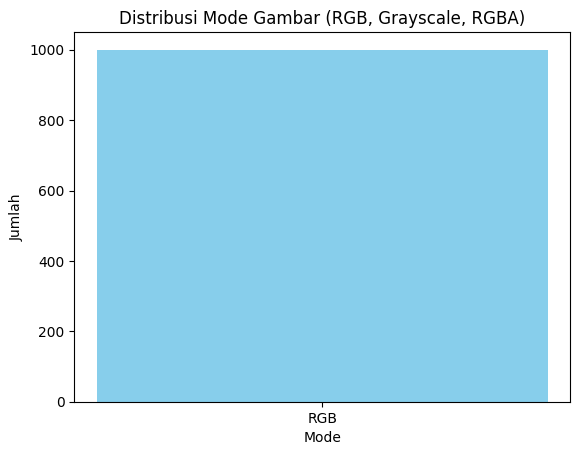

In [8]:
plt.bar(mode_counts.keys(), mode_counts.values(), color="skyblue")
plt.title("Distribusi Mode Gambar (RGB, Grayscale, RGBA)")
plt.xlabel("Mode")
plt.ylabel("Jumlah")
plt.show()

Dari boxplot di atas dapat kita simpulkan bahwa representasi warna pada setiap foto sudah balance / konsisten

### Melihat yang rusak, duplikat, dan near-duplikat

In [9]:
bad_files = []

for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    if os.path.isdir(cls_path):
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            
            # cek file kosong
            if os.path.getsize(img_path) == 0:
                bad_files.append((img_path, "Empty file"))
                continue

            # cek bisa dibuka dengan PIL
            try:
                img = Image.open(img_path)
                img.verify()  # verifikasi integritas file
            except Exception as e:
                bad_files.append((img_path, f"Corrupted: {str(e)}"))

print(f"Jumlah file rusak/bermasalah: {len(bad_files)}")
for bf in bad_files[:10]:  # tampilkan maksimal 10 contoh
    print(bf)

Jumlah file rusak/bermasalah: 0


In [10]:
hashes = {}
duplicates = []

def file_hash(path):
    with open(path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    if os.path.isdir(cls_path):
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            h = file_hash(img_path)
            if h in hashes:
                duplicates.append((img_path, hashes[h]))
            else:
                hashes[h] = img_path

print(f"Jumlah duplikat persis: {len(duplicates)}")
for d in duplicates[:10]:
    print(d)


Jumlah duplikat persis: 0


In [11]:
hashes = {}
near_duplicates = []

for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    if os.path.isdir(cls_path):
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            try:
                img = Image.open(img_path)
                h = imagehash.phash(img)
                if h in hashes:
                    near_duplicates.append((img_path, hashes[h]))
                else:
                    hashes[h] = img_path
            except:
                pass

print(f"Jumlah near-duplicate: {len(near_duplicates)}")
for nd in near_duplicates[:10]:
    print(nd)

Jumlah near-duplicate: 0


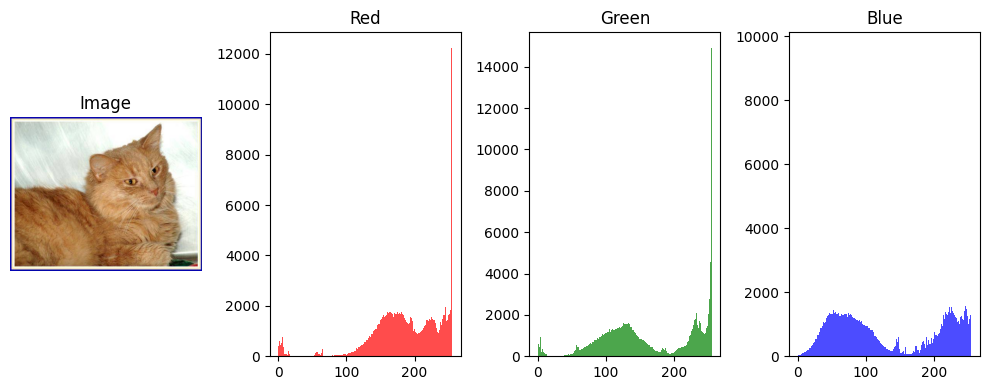

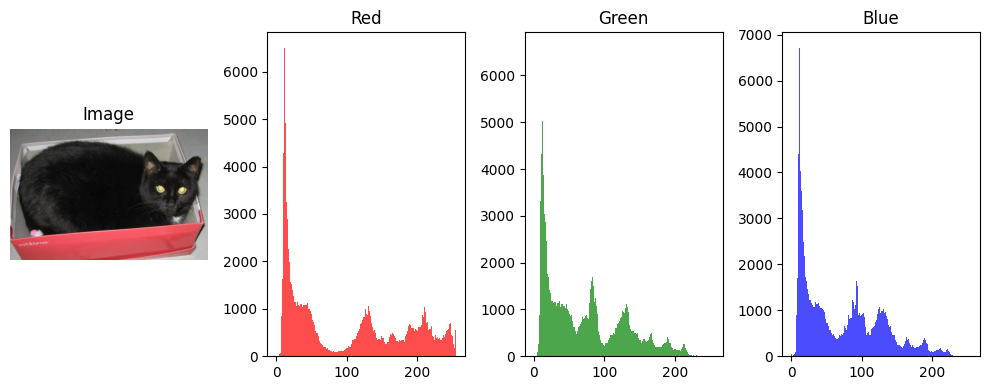

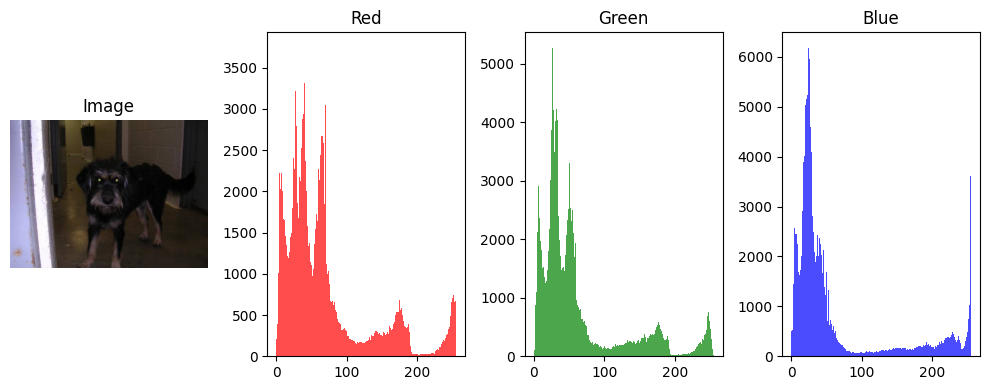

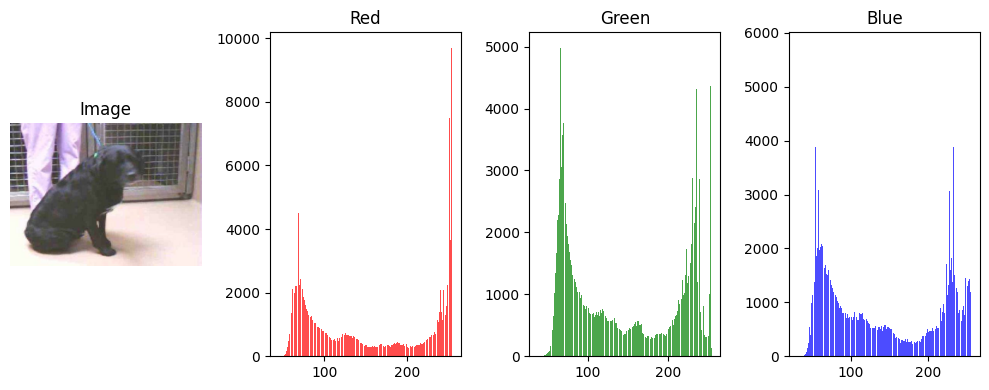

In [12]:
sample_images = []

for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    if os.path.isdir(cls_path):
        for img_name in os.listdir(cls_path)[:2]:
            sample_images.append(os.path.join(cls_path, img_name))

for img_path in sample_images:
    img = Image.open(img_path).convert("RGB")
    arr = np.array(img)

    plt.figure(figsize=(10,4))

    # Tampilkan gambar
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Image")

    # Histogram Red
    plt.subplot(1, 4, 2)
    plt.hist(arr[:,:,0].ravel(), bins=256, color="red", alpha=0.7)
    plt.title("Red")

    # Histogram Green
    plt.subplot(1, 4, 3)
    plt.hist(arr[:,:,1].ravel(), bins=256, color="green", alpha=0.7)
    plt.title("Green")

    # Histogram Blue
    plt.subplot(1, 4, 4)
    plt.hist(arr[:,:,2].ravel(), bins=256, color="blue", alpha=0.7)
    plt.title("Blue")

    plt.tight_layout()
    plt.show()

Output diatas adalah visualisasi dari distribusi intensitas warna per channel (RGB) pada beberapa sample gambar, untuk mengecek kecenderungan terang/gelap

In [13]:
pixels = []

for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    if os.path.isdir(cls_path):
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            try:
                img = Image.open(img_path).convert("RGB")
                arr = np.array(img) / 255.0  # normalisasi ke [0,1]
                pixels.append(arr.reshape(-1, 3))
            except:
                continue

pixels = np.vstack(pixels)  # gabungkan semua pixel

mean = pixels.mean(axis=0)
std = pixels.std(axis=0)

print("Mean per channel (R,G,B):", mean)
print("Std per channel  (R,G,B):", std)

Mean per channel (R,G,B): [0.48599584 0.45401001 0.41523673]
Std per channel  (R,G,B): [0.26197199 0.25584864 0.26000097]


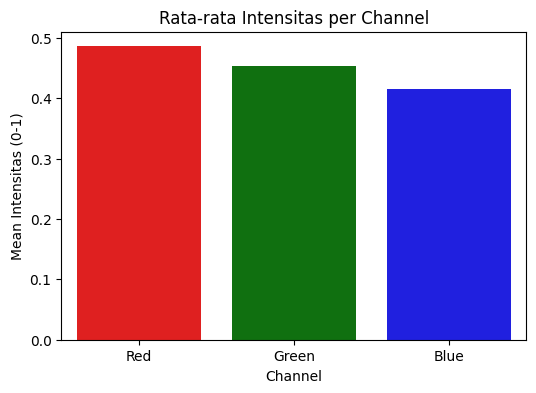

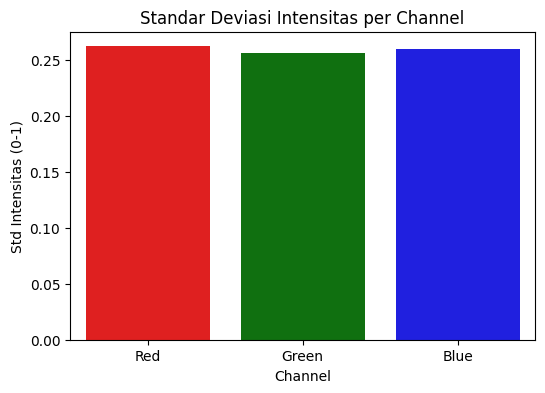

In [14]:
channels = ['Red', 'Green', 'Blue']

# buat dataframe
df = pd.DataFrame({
    'Channel': channels,
    'Mean': mean,
    'Std': std
})

plt.figure(figsize=(6,4))
sns.barplot(x='Channel', y='Mean', hue='Channel', data=df, palette=['red','green','blue'], legend=False)
plt.title("Rata-rata Intensitas per Channel")
plt.ylabel("Mean Intensitas (0-1)")
plt.show()

# plot barplot std per channel
plt.figure(figsize=(6,4))
sns.barplot(x='Channel', y='Std', hue='Channel', data=df, palette=['red','green','blue'], legend=False)
plt.title("Standar Deviasi Intensitas per Channel")
plt.ylabel("Std Intensitas (0-1)")
plt.show()

Output diatas gunanya untuk melihat rata rata dan standar deviasi dari intensitas warna pada setiap channel (RGB) pada setiap gambar

Shape fitur sebelum t-SNE: (300, 12288)


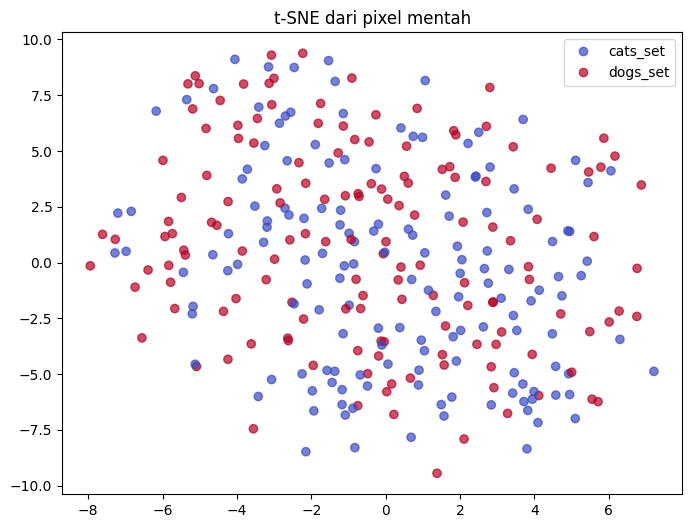

In [ ]:
import random
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# ===== Preprocessing sederhana =====
transform = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(base_dir, transform=transform)

# Sampling biar tidak berat
subset_size = 300
indices = random.sample(range(len(dataset)), subset_size)
subset = torch.utils.data.Subset(dataset, indices)
loader = torch.utils.data.DataLoader(subset, batch_size=32, shuffle=False)

# ===== Ambil pixel data sebagai fitur =====
features, labels = [], []
for imgs, lbls in loader:
    # (batch, C, H, W) → (batch, C*H*W)
    flat = imgs.view(imgs.size(0), -1)
    features.append(flat)
    labels.extend(lbls.tolist())

features = torch.cat(features).numpy()
labels = np.array(labels)

print("Shape fitur sebelum t-SNE:", features.shape)

# ===== t-SNE =====
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb2d = tsne.fit_transform(features)

# ===== Plot =====
plt.figure(figsize=(8,6))
scatter = plt.scatter(emb2d[:,0], emb2d[:,1], c=labels, cmap="coolwarm", alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=dataset.classes)
plt.title("t-SNE dari pixel mentah")
plt.show()


Scatter plot itu merepresentasikan 300 gambar yang setiap gambarnya diubah menjadi vektor pixel (fitur mentah), lalu direduksi dimensinya menjadi 2D dengan t-SNE. Setiap titik itu mewakili satu gambar, dan posisi titik menunjukkan kemiripan visual antar gambar berdasarkan pixel mentahnya.